<center> <b><font size = '6'> 
    Car Prices Prediction 
<b/><center/>

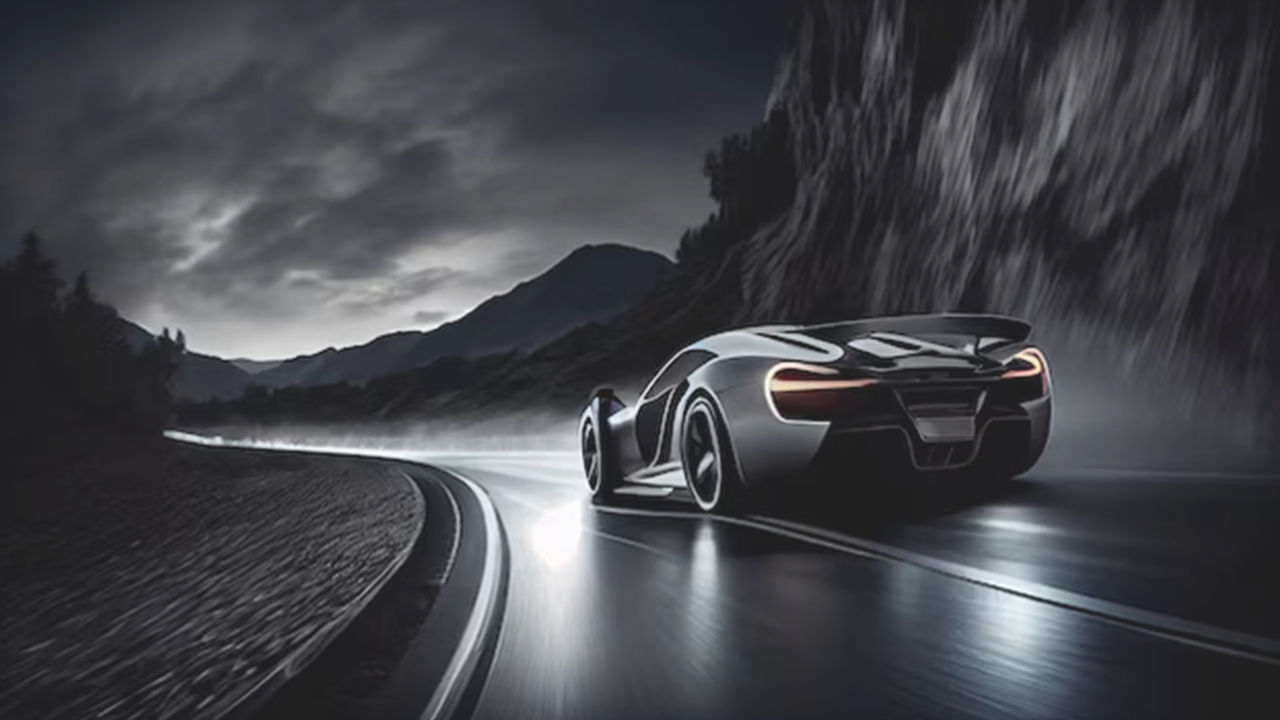

In [1]:
from IPython.display import display, Image
display(Image(r'C:\Users\domingosdeeularia\Documents\notyourbusiness\CodingAndAnalytics\Python\Projects\CarPricesPrediction\CarPricesCover.png'))

## Summary

## Main Libraries

In [2]:
# Data manipulation
import pandas as pd
import re

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing and training
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split as tts, cross_val_score as cv, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression as lreg, Lasso, Ridge, ElasticNet
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape, r2_score as r2

# Serialization
import joblib as jbl

# Function to retrieve candidate models evaluation metrics
from eval_models.eval_models import eval_reg


# Ignoring warnings
from warnings import filterwarnings as fw
fw('ignore')

## Data Preparation

In [3]:
# Importing the dataset

file = r'C:\Users\domingosdeeularia\Documents\notyourbusiness\CodingAndAnalytics\Python\Projects\CarPricesPrediction\CarPricesDataset.csv'
df = pd.read_csv(file)
df.head()

,year,make,transmission,condition,odometer,color,interior,mmr,sellingprice
0,2015,Kia,automatic,5.0,16639.0,white,black,20500.0,21500.0
1,2015,Kia,automatic,5.0,9393.0,white,beige,20800.0,21500.0
2,2014,BMW,automatic,45.0,1331.0,gray,black,31900.0,30000.0
3,2015,Volvo,automatic,41.0,14282.0,white,black,27500.0,27750.0
4,2014,BMW,automatic,43.0,2641.0,gray,black,66000.0,67000.0


In [4]:
# Info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   transmission  493485 non-null  object 
 3   condition     547017 non-null  float64
 4   odometer      558743 non-null  float64
 5   color         558088 non-null  object 
 6   interior      558088 non-null  object 
 7   mmr           558799 non-null  float64
 8   sellingprice  558825 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 38.4+ MB


In [5]:
# Missing values

df.isna().sum()

year                0
make            10301
transmission    65352
condition       11820
odometer           94
color             749
interior          749
mmr                38
sellingprice       12
dtype: int64

In [6]:
# Dropping missing values

df.dropna(inplace = True)

In [7]:
# Passing all the makes to uper case

df['make'] = df.make.str.upper()
df.make.unique()

array(['KIA', 'BMW', 'VOLVO', 'NISSAN', 'CHEVROLET', 'AUDI', 'FORD',
       'CADILLAC', 'ACURA', 'LEXUS', 'HYUNDAI', 'BUICK', 'INFINITI',
       'JEEP', 'MERCEDES-BENZ', 'MITSUBISHI', 'MAZDA', 'MINI',
       'LAND ROVER', 'LINCOLN', 'JAGUAR', 'VOLKSWAGEN', 'TOYOTA',
       'SUBARU', 'SCION', 'PORSCHE', 'DODGE', 'FIAT', 'CHRYSLER',
       'FERRARI', 'HONDA', 'GMC', 'RAM', 'SMART', 'BENTLEY', 'PONTIAC',
       'SATURN', 'MASERATI', 'MERCURY', 'HUMMER', 'LANDROVER', 'MERCEDES',
       'SAAB', 'SUZUKI', 'OLDSMOBILE', 'DODGE TK', 'ROLLS-ROYCE', 'ISUZU',
       'FORD TK', 'PLYMOUTH', 'VW', 'FORD TRUCK', 'TESLA', 'AIRSTREAM',
       'DOT', 'GMC TRUCK', 'ASTON MARTIN', 'GEO', 'MERCEDES-B', 'FISKER',
       'DAEWOO', 'LAMBORGHINI', 'LOTUS'], dtype=object)

In [8]:
# Remove some makes variants or misspellings

remove_some_makes = lambda make: re.split(r'[- ]', make)[0] if  make not in ['LAND ROVER', 'ASTON MARTIN', 'ROLLS-ROYCE'] else make

df['make' ] = df.make.map(remove_some_makes)

print(set(df.make))

{'BMW', 'SAAB', 'LAND ROVER', 'INFINITI', 'PONTIAC', 'MERCEDES', 'MERCURY', 'FIAT', 'SUZUKI', 'CADILLAC', 'KIA', 'SUBARU', 'GEO', 'HUMMER', 'AIRSTREAM', 'FISKER', 'TESLA', 'CHRYSLER', 'DOT', 'DAEWOO', 'MAZDA', 'HONDA', 'PLYMOUTH', 'SATURN', 'LAMBORGHINI', 'BENTLEY', 'JEEP', 'CHEVROLET', 'LOTUS', 'GMC', 'JAGUAR', 'OLDSMOBILE', 'MITSUBISHI', 'HYUNDAI', 'ACURA', 'FERRARI', 'LINCOLN', 'LANDROVER', 'VOLKSWAGEN', 'BUICK', 'TOYOTA', 'PORSCHE', 'MASERATI', 'VOLVO', 'ASTON MARTIN', 'RAM', 'SMART', 'ROLLS-ROYCE', 'DODGE', 'MINI', 'LEXUS', 'FORD', 'SCION', 'VW', 'ISUZU', 'NISSAN', 'AUDI'}


In [9]:
# Replacement for Land Rover and Volkswagen

replace_makes = lambda make: 'LAND ROVER' if make == 'LANDROVER' else 'VOLKSWAGEN' if make == 'VW' else make

df['make' ] = df.make.map(replace_makes)

print(set(df.make))

{'BMW', 'SAAB', 'LAND ROVER', 'INFINITI', 'PONTIAC', 'MERCEDES', 'MERCURY', 'FIAT', 'SUZUKI', 'CADILLAC', 'KIA', 'SUBARU', 'GEO', 'HUMMER', 'AIRSTREAM', 'FISKER', 'TESLA', 'CHRYSLER', 'DOT', 'DAEWOO', 'MAZDA', 'HONDA', 'PLYMOUTH', 'SATURN', 'LAMBORGHINI', 'BENTLEY', 'JEEP', 'CHEVROLET', 'LOTUS', 'GMC', 'JAGUAR', 'OLDSMOBILE', 'MITSUBISHI', 'HYUNDAI', 'ACURA', 'FERRARI', 'LINCOLN', 'VOLKSWAGEN', 'BUICK', 'TOYOTA', 'PORSCHE', 'MASERATI', 'VOLVO', 'ASTON MARTIN', 'RAM', 'SMART', 'ROLLS-ROYCE', 'DODGE', 'MINI', 'LEXUS', 'FORD', 'SCION', 'ISUZU', 'NISSAN', 'AUDI'}


In [10]:
# Passing the categorical columns except 'make' to title style

col_cat_diff_make = df.dtypes[(df.dtypes == object) & (df.dtypes.index != 'make')].index

df[col_cat_diff_make] = df[col_cat_diff_make].map(lambda cell: cell.title())

df[col_cat_diff_make].head()

,transmission,color,interior
0,Automatic,White,Black
1,Automatic,White,Beige
2,Automatic,Gray,Black
3,Automatic,White,Black
4,Automatic,Gray,Black


In [11]:
# Lists of numerical and Categorical Atributtes

col_num = list(df.dtypes[df.dtypes != object].index)
col_cat = list(df.dtypes[df.dtypes == object].index)

In [12]:
# Pipeline for numerical attributes

pipe_num = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'mean'))])

In [13]:
# Pipeline for categorical attributes

pipe_cat = Pipeline(steps = [
    ('imputer', SimpleImputer(missing_values = '—', strategy = 'most_frequent'))])

In [14]:
# Composing the whole pipelines

preprocessor_ = ColumnTransformer(transformers = [
    ('num', pipe_num, col_num),
    ('cat', pipe_cat, col_cat)])

prep_pipeline = Pipeline( steps = [('preprocessor', preprocessor_)])

In [15]:
# Fitting the pipeline in the dataframe

prep_transf = prep_pipeline.fit_transform(df)

In [16]:
# Columns after transformation arrangement

cols_prep = [i[5:] for i in preprocessor_.get_feature_names_out()]

In [17]:
# Transformed dataframe

df_prep = pd.DataFrame(prep_transf, columns = cols_prep)


# Ordering as in the original dataframe

df_prep = df_prep[df.columns]

In [18]:
# Types after transformation

df_prep.dtypes.value_counts()

object    9
Name: count, dtype: int64

In [19]:
# Conversion for numeric columns

for col in col_num:
    df_prep[col] = df_prep[col].astype(float)

In [20]:
# Types after transformation after conversion

df_prep.dtypes.value_counts()

float64    5
object     4
Name: count, dtype: int64

In [21]:
# Saving the preprocessed dataset

df_prep.to_csv(file.replace('CarPricesDataset.csv', 'CarPricesPreprocessedDataset.csv'))

## Exploratory Data Analysis

In [22]:
# First rows of the preprocessing dataframe

df_prep.head()

,year,make,transmission,condition,odometer,color,interior,mmr,sellingprice
0,2015.0,KIA,Automatic,5.0,16639.0,White,Black,20500.0,21500.0
1,2015.0,KIA,Automatic,5.0,9393.0,White,Beige,20800.0,21500.0
2,2014.0,BMW,Automatic,45.0,1331.0,Gray,Black,31900.0,30000.0
3,2015.0,VOLVO,Automatic,41.0,14282.0,White,Black,27500.0,27750.0
4,2014.0,BMW,Automatic,43.0,2641.0,Gray,Black,66000.0,67000.0


In [23]:
# Statiscical summary

df.describe(include = 'all')

,year,make,transmission,condition,odometer,color,interior,mmr,sellingprice
count,474497.000000,474497,474497,474497.000000,474497.000000,474497,474497,474497.000000,474497.000000
unique,NaN,55,2,NaN,NaN,20,17,NaN,NaN
top,NaN,FORD,Automatic,NaN,NaN,Black,Black,NaN,NaN
freq,NaN,81281,458015,NaN,NaN,93631,210498,NaN,NaN
mean,2010.189852,NaN,NaN,30.747602,66919.836819,NaN,NaN,13819.596699,13673.519681
std,3.838819,NaN,NaN,13.292818,52108.511803,NaN,NaN,9563.462245,9644.283541
min,1984.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,25.000000,1.000000
25%,2008.000000,NaN,NaN,24.000000,28198.000000,NaN,NaN,7400.000000,7100.000000
50%,2012.000000,NaN,NaN,35.000000,51306.000000,NaN,NaN,12300.000000,12200.000000
75%,2013.000000,NaN,NaN,41.000000,96921.000000,NaN,NaN,18250.000000,18200.000000


In [24]:
# Correlation on numerical attributes

df_corr = df_prep[col_num].corr()
df_corr

,year,condition,odometer,mmr,sellingprice
year,1.000000,0.336624,-0.772495,0.588387,0.578738
condition,0.336624,1.000000,-0.315425,0.277735,0.318697
odometer,-0.772495,-0.315425,1.000000,-0.582398,-0.577192
mmr,0.588387,0.277735,-0.582398,1.000000,0.983587
sellingprice,0.578738,0.318697,-0.577192,0.983587,1.000000


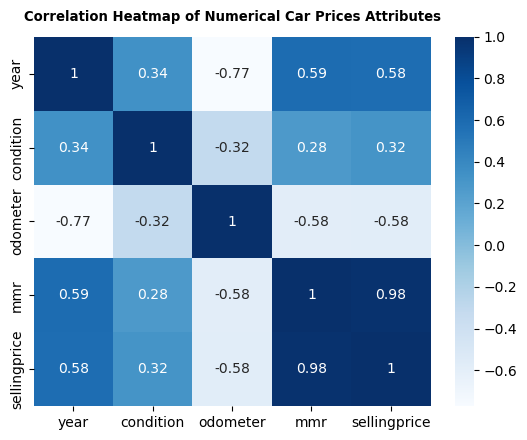

In [25]:
# Plotting the Heatmap

plt.title('Correlation Heatmap of Numerical Car Prices Attributes', y = 1.02, fontsize = 9.5, fontweight = 'bold')
sns.heatmap(df_corr, annot = True, cmap = 'Blues')
plt.show()

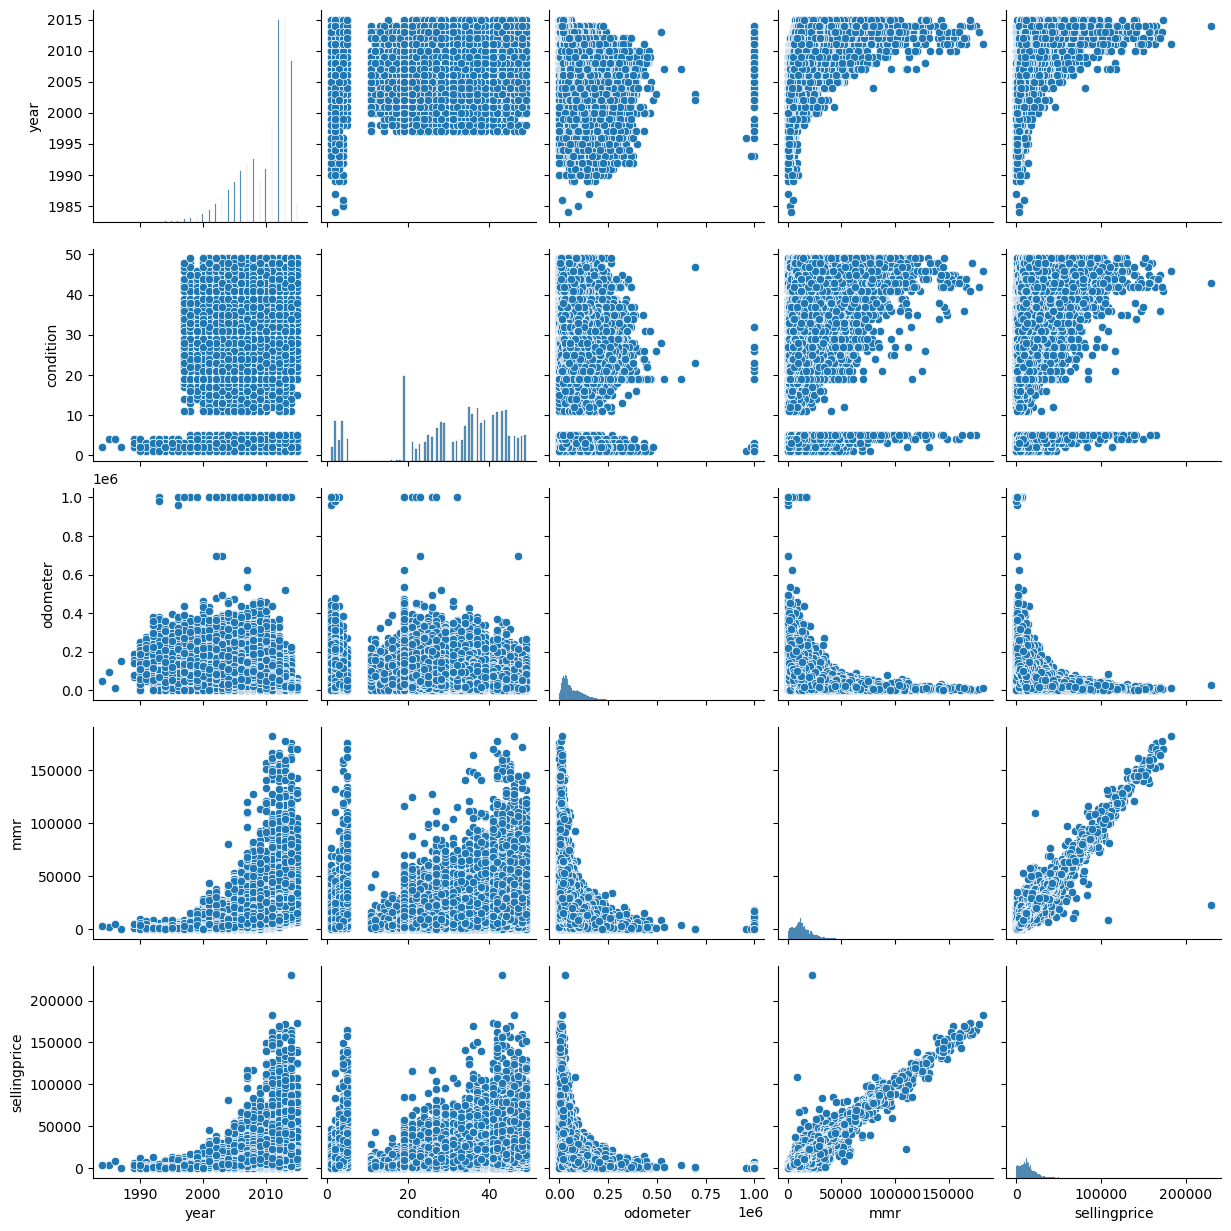

In [26]:
# Displaying the pairplot

sns.pairplot(df_prep)
plt.show()

## Model Training

In [27]:
# Target and predictors (with one-hot-encoding)

y, X = df_prep.sellingprice, df_prep.drop(columns = ['sellingprice'])

X = pd.get_dummies(X, drop_first = True)

In [28]:
# Splitting the dataframe into train and test sets

X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 7)

In [29]:
# Passing the dataframe to arrays

X_train_array, X_test_array, y_train_array, y_test_array = X_train.values, X_test.values, y_train.values, y_test.values

In [30]:
# Instantiation of XGB Regressor

xgb_reg = xgb.XGBRegressor(max_depth = 6, learning_rate = 0.25, 
                           random_state = 7)

In [31]:
# Dictionary of candidate models and their instances

candidate_models = {'OLS': lreg(), 'Lasso': Lasso(), 'Ridge': Ridge(),
                    'ElasticNet': ElasticNet(), 'XGB': xgb_reg}

In [32]:
# Scores evaluation

scores = eval_reg(candidate_models, X_train_array, y_train_array)
scores

,Model,Mean Score
1,Lasso,-2.872643e+06
2,Ridge,-2.875875e+06
0,OLS,-2.876430e+06
3,ElasticNet,-2.900466e+06
4,XGB,-3.085912e+06


In [33]:
# Model name with best performance and its instance

best_model_name = scores.iat[0,0]
best_model_instance = candidate_models[best_model_name]

best_model_name, best_model_instance

('Lasso', Lasso())

In [34]:
# Passing the best model pipeline

best_model_pipeline = Pipeline(steps = [
        ('scaler', RobustScaler()),
        ('feature_selection', RFE(best_model_instance)),
        ('regressor', best_model_instance)
    ])

In [35]:
# Fittng the best model and making predictions on test set

best_model = best_model_pipeline.fit(X_train_array, y_train_array)
y_pred = best_model.predict(X_test_array)
y_pred

array([12833.65706516,   975.69910466, 13098.94196885, ...,
       13973.44671284,  1290.35428524,  5149.77761238])

In [38]:
# Overall evaluation metrics

print('R2:', round(r2(y_test_array, y_pred), 3),
      '\nMSE:', round(mse(y_test_array, y_pred), 2),
      '\nRMSE:', round(mse(y_test_array, y_pred, squared = False), 2),
      '\nMAE:', round(mae(y_test_array, y_pred), 2),
      '\nMAPE (%):', round(mape(y_test_array, y_pred) * 100), 2)

R2: 0.972 
MSE: 2615846.68 
RMSE: 1617.36 
MAE: 1039.13 
MAPE (%): 15 2


In [39]:
# Saving the best model

jbl.dump(best_model_pipeline, file.replace('CarPricesDataset.csv', 'CarPricesPredictionModel.joblib'))

['C:\\Users\\domingosdeeularia\\Documents\\notyourbusiness\\CodingAndAnalytics\\Python\\Projects\\CarPricesPrediction\\CarPricesPredictionModel.joblib']

##  Data Provenance

<p>
  <strong>Source:</strong> 
  S. Anwar (Kaggle) 
  <a href = 'https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data' target = '_blank'>
    Vehicle Sales Data.
  </a>
  <br>
  <strong>License:</strong>
    <a href = 'https://www.mit.edu/~amini/LICENSE.md' target = '_blank'>
        MIT.
    </a>
    <br><br>
  <em>Last accessed on September, 14 2024.</em>
</p>

                 ________  ________   _______   ______
                 /_  __/ / / / ____/  / ____/ | / / __ \
                  / / / /_/ / __/    / __/ /  |/ / / / /
                 / / / __  / /___   / /___/ /|  / /_/ /
                /_/ /_/ /_/_____/  /_____/_/ |_/_____/  
